# Estudo da Prestação de Contas dos Recursos Captados nas Eleições de 2022 no Rio Grande do Sul

## 1. Introdução

Estamos analisando os dados de prestação de contas dos candidatos nas eleições de 2022. Os dados foram coletados da seção de dados abertos do portal gov.br.
O estudo é motivado primeiro pela vontade de aprender sobre ciência de dados, análise de dados e afins, além de claro buscar compreender padrões de como os recursos públicos foram captados e utilizados no período eleitoral de 2022.

Ao término desse estudo pretende-se responder algumas perguntas:

- Qual o valor total de receitas captado pelos partidos?
- Qual partido mais captou dinheiro no período eleitoral?
- Qual partido menos captou dinheiro no período eleitoral?
- Quais as proporções na captação de recursos para as diferentes fontes de renda?
- Quais as proporções na captação de recursos para os diferentes cargos políticos?
- Existe diferença na distribuição do fundo partidário de acordo com raça?
- Existe diferença na distribuição do fundo partidário de acordo com Gênero?
- Quais as maiores origens de receita?
- Quais as maiores especie de receita?
- Quais os maiores doadores?
- Existem doações sem recibos?
- Existem doações sem documentos?

Fonte dos Dados: https://dados.gov.br/dados/conjuntos-dados/dadosabertos-tse-jus-br-dataset-prestacao-de-contas-eleitorais-2022

## 2.Carregando Bibliotécas

In [20]:
#importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import locale

#definições
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
plt.style.use('ggplot')

#aproveitando esse bloco para definir algumas funções
formatter = FuncFormatter(lambda x, _: '{:,.0f}'.format(x))

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

## 3.Lendo os Dados

In [2]:
df_receitas = pd.read_csv('receitas_candidatos_2022_RS.csv', encoding='latin1', sep=';', parse_dates=['DT_GERACAO','DT_ELEICAO','DT_PRESTACAO_CONTAS','DT_RECEITA'], dayfirst=True, decimal=',', thousands='.')

#diminuindo um pouco a memória usada pelo dataframe transformando colunas com poucos valores no tipo category
cols_categorias = ['TP_PRESTACAO_CONTAS','SG_UF','SG_UE','DS_CARGO','DS_NATUREZA_RECEITA','CD_ESFERA_PARTIDARIA_DOADOR','DS_GENERO','DS_COR_RACA']

for c in cols_categorias:
    df_receitas[c] = df_receitas[c].astype('category')

df_receitas.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,ST_TURNO,TP_PRESTACAO_CONTAS,...,NM_PARTIDO_DOADOR,NR_RECIBO_DOACAO,NR_DOCUMENTO_DOACAO,SQ_RECEITA,DT_RECEITA,DS_RECEITA,VR_RECEITA,DS_NATUREZA_RECURSO_ESTIMAVEL,DS_GENERO,DS_COR_RACA
0,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,Partido Social Cristão,020700600000RS000002E,#NULO#,28818582,2022-08-16,LAPELAS,278.00,Publicidade por materiais impressos,Feminino,Branca
1,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,Partido Social Cristão,020700600000RS000006E,#NULO#,28818585,2022-08-17,PRODUÇÃO DE TODOS OS PROGRAMAS DE TV· COMERCIA...,2158.28,"Produção de programas de rádio, televisão ou v...",Feminino,Branca
2,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,Partido Social Cristão,020700600000RS000004E,47441214000167,28818584,2022-09-14,#NULO#,4600.00,#NULO#,Feminino,Branca
3,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,Partido Social Cristão,020700600000RS000007E,#NULO#,28818586,2022-08-17,CRIAÇÃO IDENTIDADE VISUAL,1774.41,"Produção de programas de rádio, televisão ou v...",Feminino,Branca
4,2024-05-15,02:03:43,2022,2,ORDINÁRIA,546,Eleições Gerais Estaduais 2022,2022-10-02,1,FINAL,...,Partido Social Cristão,020700600000RS000001E,#NULO#,28818581,2022-08-16,FLYERS,2040.00,Publicidade por materiais impressos,Feminino,Branca


In [3]:
df_receitas.shape

(22252, 60)

In [4]:
df_receitas.isnull().sum()

DT_GERACAO                        0
HH_GERACAO                        0
ANO_ELEICAO                       0
CD_TIPO_ELEICAO                   0
NM_TIPO_ELEICAO                   0
CD_ELEICAO                        0
DS_ELEICAO                        0
DT_ELEICAO                        0
ST_TURNO                          0
TP_PRESTACAO_CONTAS               0
DT_PRESTACAO_CONTAS               0
SQ_PRESTADOR_CONTAS               0
SG_UF                             0
SG_UE                             0
NM_UE                             0
NR_CNPJ_PRESTADOR_CONTA           0
CD_CARGO                          0
DS_CARGO                          0
SQ_CANDIDATO                      0
NR_CANDIDATO                      0
NM_CANDIDATO                      0
NR_CPF_CANDIDATO                  0
NR_CPF_VICE_CANDIDATO             0
NR_PARTIDO                        0
SG_PARTIDO                        0
NM_PARTIDO                        0
CD_FONTE_RECEITA                  0
DS_FONTE_RECEITA            

## 4.Analisando algumas variáveis

In [22]:
valor_total = df_receitas['VR_RECEITA'].sum()
formatar_moeda(valor_total)

'R$ 308.070.543,07'

**O valor total captado na política em 2022 no Rio Grande do Sul foi de pouco mais de 300 milhões.**

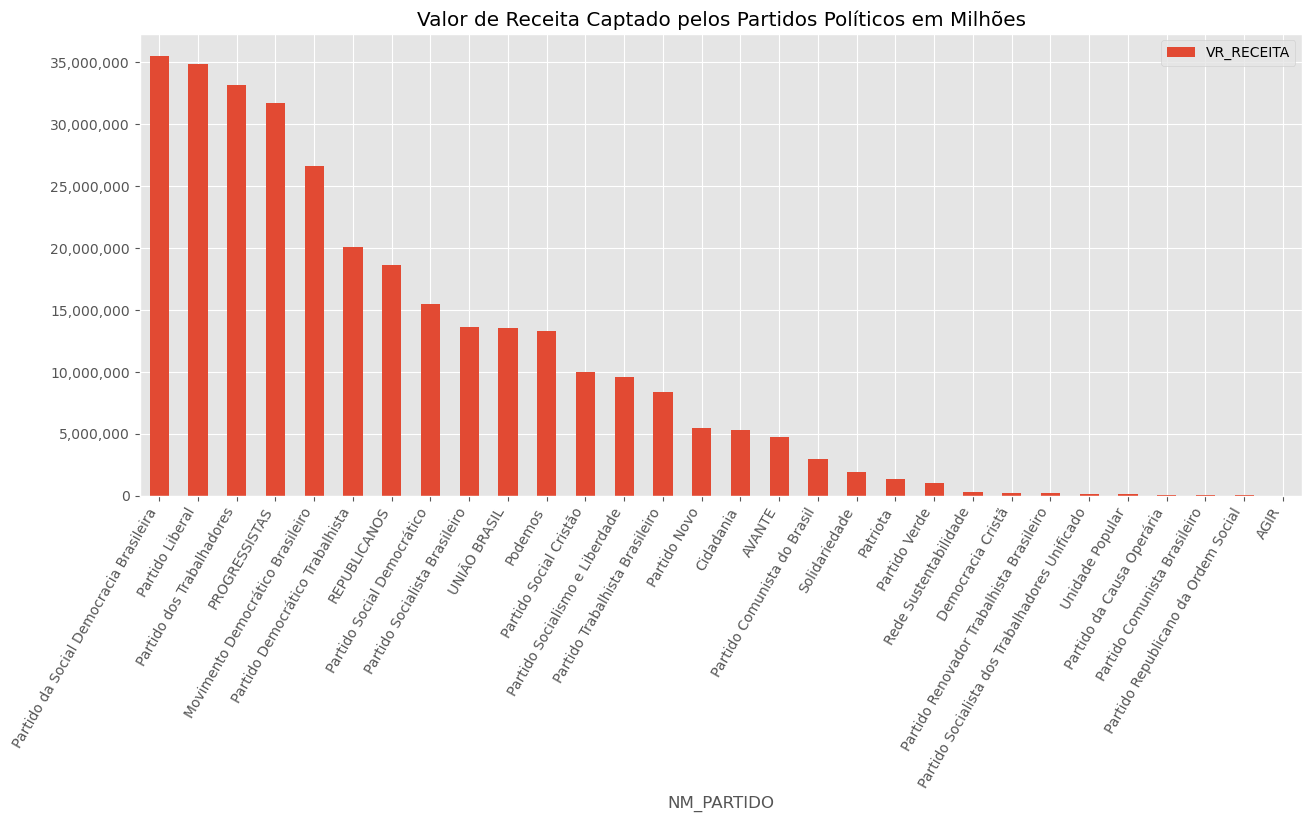

In [45]:
df_grupo = df_receitas[['NM_PARTIDO','VR_RECEITA']].groupby('NM_PARTIDO').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(15,6))
_ = df_grupo.plot.bar(ax=ax)
plt.title('Valor de Receita Captado pelos Partidos Políticos em Milhões')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

O partido que mais captou dinheiro foi o **Partido da Social Democracia Brasileira (Mais de 35 milhões)** seguido do Partido Liberal e Partido dos Trabalhadores e Progressistas, sendo os 4 primeiros partidos tendo captado mais de 30 milhões de reais cada um.
O partido que menos captou dinheiro foi **AGIR**.

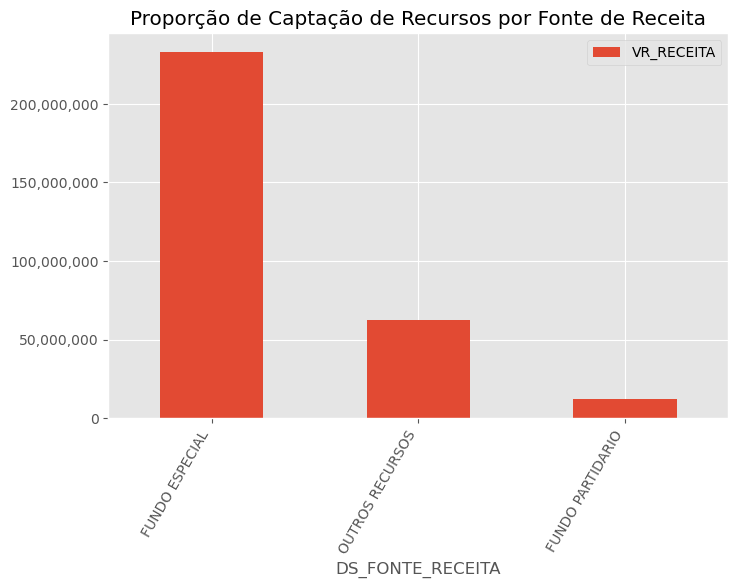

In [52]:
df_grupo = df_receitas[['DS_FONTE_RECEITA','VR_RECEITA']].groupby('DS_FONTE_RECEITA').sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
_ = df_grupo.plot.bar(ax=ax)
_ = plt.title('Proporção de Captação de Recursos por Fonte de Receita')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

In [ ]:
Como se pode ver, acima as proporções em porcentagem para as diferentes Fonte de Receita.

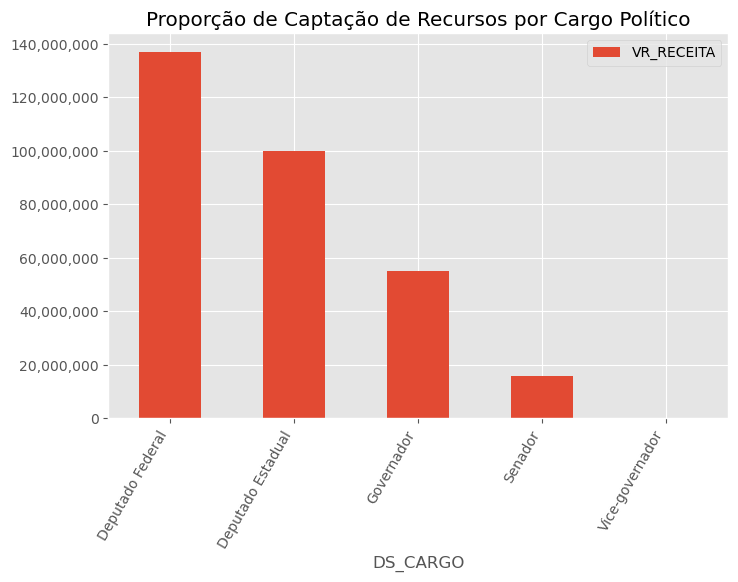

In [53]:
df_grupo = df_receitas[['DS_CARGO','VR_RECEITA']].groupby('DS_CARGO', observed=False).sum().sort_values(by='VR_RECEITA', ascending=False)

fig, ax = plt.subplots(figsize=(8,5))
_ = df_grupo.plot.bar(ax=ax)
_ = plt.title('Proporção de Captação de Recursos por Cargo Político')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
ax.yaxis.set_major_formatter(formatter)

## 5. Algumas análises bivariaveis

/home/fmachado/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


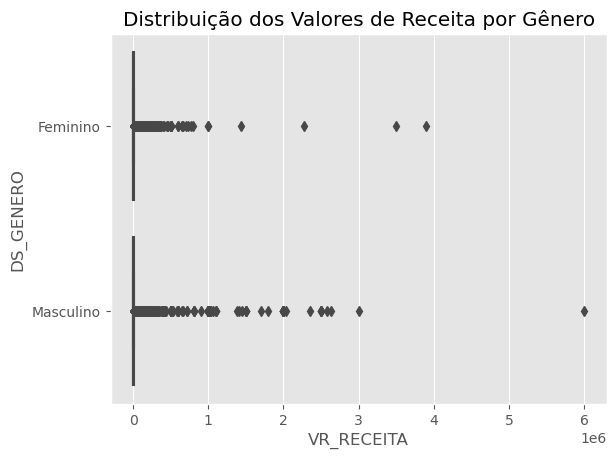

In [101]:
plt.title('Distribuição dos Valores de Receita por Gênero')
_ = sns.boxplot(y='DS_GENERO', x='VR_RECEITA', data=df_receitas)